# Running calculations for the manuscript "The chemical forces underlying tilting distortions in halide perovskites"

## Requirements:

* Jupyter notebooks
* Matplotlib
* Numpy
* GULP - interatomic potential simulation software

## Scope

The code below will recreate all of the calculations presented in the paper. It should also be possible to extend the code to include different spacegroups and adapt the interatomic potentials to your own needs.

## Step 1: Setting up the environment

The majority of these settings are actually just related to how the plots look by default.


In [5]:
%matplotlib inline
import numpy as np
import os
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.facecolor'] = (0.9,0.9,0.9)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = False
mpl.rcParams['grid.color'] = 'w'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['legend.fontsize'] = 22
mpl.rcParams['legend.facecolor'] = [1,1,1]
mpl.rcParams['legend.framealpha'] = 0.75
mpl.rcParams['axes.labelsize'] = 22

## Step 2: Define some helper functions

These functions do some of the simple tasks needed for the calculations in the paper.

`get_x_charge`: Based on the charges of the A and B sites, it gets the X charge from the principle of charge neutrality.

`get_k`: In order to keep the polarisation of the X anion constant it is necessary to vary the spring constant to reflect the different charge. This function calculates the required spring constant. `k` is originally set to 28.006 by default, but this can be chaged if desired.

`rungulp`: This function provides a shell command to run `GULP`. You need to make sure that the executable name in this command is correct - for my case the executable command is simply `gulp`.

`get_energy`: This function parses the `GULP` output file and returns the lattice energy of the optimised system.

In [6]:
def get_x_charge(qa, qb):
    return float(-(qa + qb)/3)

def get_k(q, k=28.006):
    return float(k * q * q )

def rungulp(inputfile):
    os.system('gulp < %s > out.tmp' % inputfile)
    return

def get_energy(outfile):
   with open(outfile) as o:
    content = o.readlines()
    for line in content:
        inp = line.split()
        if len(inp) > 0 and inp[0] == 'Final' and inp[1] == 'energy':
            return float(inp[3])

## Step 3: Define some functions to set up the calculations

* `vary_charges` sets up a range of calculations spanning `range_a` and `range_b` in the ionic charges of sites A and B respectively. The spacegroups to compare are defined using the spacegroup number for `spg_a` and `spg_b`. `factor` is the number of formula units/unit cell in the setup, it is needed to scale the energy. You can also chage several of the Buckingham potential parameters if desired. 

* `vary_repulsion` sets up a range of calculations spanning `range_a` and `range_b` in the pre-exponential factors for repulsion of sites A and B respectively. The spacegroups to compare are defined using the spacegroup number for `spg_a` and `spg_b`. `factor` is the number of formula units/unit cell in the setup, it is needed to scale the energy. You can also chage several of the Buckingham potential parameters if desired.

In [41]:
def vary_charges(range_a, range_b, spg_a, spg_b, factor, ko=28.006, disp=40, r_b=1482.300, r_a=3521.60):

    energy_difference = []
    for qa in range_a:
        for qb in range_b:
            qx = get_x_charge(qa, qb)
            qx_shell = qx - 0.378
            k = get_k(qx, ko)
            inputfile = spg_a(qa, qb, qx_shell, k, disp, r_b, r_a)
            rungulp(inputfile)
            energy_ref = get_energy('out.tmp')
            inputfile = spg_b(qa, qb, qx_shell, k, disp, r_b, r_a)
            rungulp(inputfile)
            energy = get_energy('out.tmp')
            de = energy_ref - energy / factor
            energy_difference.append([qa, qb, de])
    return energy_difference

def vary_repulsion(range_a, range_b, spg_a, spg_b, factor, ko=28.006, disp=40):

    energy_difference = []
    for qa in range_a:
        for qb in range_b:
            qx = get_x_charge(1., 2.)
            qx_shell = qx - 0.378
            k = get_k(qx, ko)
            inputfile = spg_a(1.0, 2.0, qx_shell, k, disp, r_b=qb, r_a=qa)
            rungulp(inputfile)
            energy_ref = get_energy('out.tmp')
            inputfile = spg_b(1.0, 2.0, qx_shell, k, disp, r_b=qb, r_a=qa)
            rungulp(inputfile)
            energy = get_energy('out.tmp')
            de = energy_ref - energy / factor
            energy_difference.append([qa, qb, de])
    return energy_difference

## Step 4: Define some functions to plot the energy differences

In [52]:
def plot_difference(energy_difference, savefile='default', display=True):
    energy_difference = np.asarray(energy_difference)
    xi = np.linspace(min(energy_difference[:,0]), max(energy_difference[:,0]), 100)
    yi = np.linspace(min(energy_difference[:,1]), max(energy_difference[:,1]), 100)
    zi = griddata((energy_difference[:,0], energy_difference[:,1]), energy_difference[:,2],
             (xi[None,:], yi[:,None]))
    fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    cax = ax.contourf(xi, yi, zi, 15, cmap=plt.cm.viridis)
    ax.contour(xi, yi, zi, colors='black')
    cbar = plt.colorbar(cax)
    ax.set_xlabel('Q$_A$ (e)')
    ax.set_ylabel('Q$_B$ (e)')
    cbar.set_label('$\Delta$ E (eV/u.c.)')
    plt.tight_layout()
    if savefile == 'default':
        default = 1
    else:
        plt.savefig(savefile)
        
    if display:
        plt.show()

def plot_difference_radius(energy_difference, savefile='default', display=True):
    energy_difference = np.asarray(energy_difference)
    xi = np.linspace(min(energy_difference[:,0]), max(energy_difference[:,0]), 100)
    yi = np.linspace(min(energy_difference[:,1]), max(energy_difference[:,1]), 100)
    zi = griddata((energy_difference[:,0], energy_difference[:,1]), energy_difference[:,2],
             (xi[None,:], yi[:,None]))
    fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    cax = ax.contourf(xi, yi, zi, 15, cmap=plt.cm.viridis)
    ax.contour(xi, yi, zi, colors='black')
    cbar = plt.colorbar(cax)
    ax.set_xlabel('A$_A$ (eV)')
    ax.set_ylabel('A$_B$ (eV)')
    cbar.set_label('$\Delta$ E (eV/u.c.)')
    plt.tight_layout()
    if savefile == 'default':
        default = 1
    else:
        plt.savefig(savefile)
    
    if display:
        plt.show()

## Step 5: Define a function to write the potential form

In [32]:
def write_potential_details(filename, qa, qb, qx_shell, r_b, disp, r_a, k):
        filename.write('species \n')
        filename.write('K   core        %5.2f \n' % qa)
        filename.write('Ca  core        %5.2f \n' % qb)
        filename.write('F core     0.378 \n')
        filename.write('F shel     %20.12f \n' % qx_shell)
        filename.write('buckingham \n')
        filename.write('K   core K core   2189.190 0.1916   0.00 0.0 10.0 \n')
        filename.write('Ca  core F shel   %8.3f 0.2664   0.00 0.0 10.0 \n' % r_b)
        filename.write('F   shel F shel    911.690 0.2707   %5.3f 0.0 10.0 \n' % disp)
        filename.write('K   core F shel   %8.3f  0.2672   0.00 0.0 10.0 \n' % r_a)
        filename.write('spring \n')
        filename.write('F  %10.3f \n' % k)

## Step 6: Define functions to write input files

Depending on the spacegroup number provided to the function in step 3, we write different input files. These functions should not need to be changed in principle, as all inputs are defined in step 3. However, if one wishes to study different spacegroups, this is the section of the code to add them in.

The naming convention of the output file `filename` is not terribly important, as it will be dealt with in the `vary_x` function. In this case I gave each varient its own uniqie filename to allow inspection afterwards to ensure the the calculations were correctly defined.

In [35]:
def write_221(qa, qb, qx_shell, k, disp=40.0, r_b=1482.300, r_a=3521.60):
        filename = open('221-%4.2f-%4.2f.gin' % (qa, qb), 'w')
        filename.write('opti cellonly \n')
        filename.write('cell \n')
        filename.write('4.1889 4.1889 4.1889 90.000 90.000 90.000 \n')
        filename.write('Frac \n')
        filename.write('Ca  core        0.0000  0.0000  0.0000 \n')
        filename.write('K   core        0.5000  0.5000  0.5000 \n')
        filename.write('F   core        0.5000  0.0000  0.0000 \n')
        filename.write('space \n')
        filename.write('221 \n')
        write_potential_details(filename, qa, qb, qx_shell, r_b, disp, r_a, k)
        filename.close()
        return '221-%4.2f-%4.2f.gin' % (qa, qb)
        
def write_140(qa, qb, qx_shell, k, disp=40.0, r_b=1482.300, r_a=2189.190):
        filename = open('140-%4.2f-%4.2f.gin' % (qa, qb), 'w')
        filename.write('opti cellonly \n')
        filename.write('cell \n')
        filename.write('5.86330 5.86330 7.84700 90.000 90.000 90.000 \n')
        filename.write('Frac \n')
        filename.write('Ca  core        0.0000  0.5000  0.0000 \n')
        filename.write('K   core        0.0000  0.0000  0.2500 \n')
        filename.write('F   core        0.0000  0.5000  0.2500 \n')
        filename.write('F   core        0.2276  0.7276  0.0000 \n')
        filename.write('space \n')
        filename.write('140 \n')
        write_potential_details(filename, qa, qb, qx_shell, r_b, disp, r_a, k)
        filename.close()
        return '140-%4.2f-%4.2f.gin' % (qa, qb)
    
def write_127(qa, qb, qx_shell, k, disp=40.0, r_b=1482.300, r_a=2189.190):
        filename = open('127-%4.2f-%4.2f.gin' % (qa, qb), 'w')
        filename.write('opti cellonly \n')
        filename.write('cell \n')
        filename.write('5.85430 5.85430 3.93030 90.000 90.000 90.000 \n')
        filename.write('Frac \n')
        filename.write('Ca  core        0.0000  0.5000  0.0000 \n')
        filename.write('K   core        0.0000  0.0000  0.5000 \n')
        filename.write('F   core        0.0000  0.5000  0.5000 \n')
        filename.write('F   core        0.2273  0.7273  0.0000 \n')
        filename.write('space \n')
        filename.write('127 \n')
        write_potential_details(filename, qa, qb, qx_shell, r_b, disp, r_a, k)
        filename.close()
        return '127-%4.2f-%4.2f.gin' % (qa, qb)
    
def write_62(qa, qb, qx_shell, k, disp=40.0, r_b=1482.300, r_a=2189.190):
        filename = open('62-%4.2f-%4.2f.gin' % (qa, qb), 'w')
        filename.write('opti cellonly \n')
        filename.write('cell \n')
        filename.write('5.75100 8.00800 5.54800 90.000 90.000 90.000 \n')
        filename.write('Frac \n')
        filename.write('Ca  core        0.5000  0.5000  0.5000 \n')
        filename.write('K   core        0.0543  0.7500  0.5127 \n')
        filename.write('F   core        0.3053  0.5603  0.8093 \n')
        filename.write('F   core        0.4469  0.7500  0.3854 \n')
        filename.write('space \n')
        filename.write('62 \n')
        write_potential_details(filename, qa, qb, qx_shell, r_b, disp, r_a, k)
        filename.close()
        return '62-%4.2f-%4.2f.gin' % (qa, qb)
    
def write_12(qa, qb, qx_shell, k, disp=40.0, r_b=1482.300, r_a=2189.190):
        filename = open('12-%4.2f-%4.2f.gin' % (qa, qb), 'w')
        filename.write('opti cellonly \n')
        filename.write('cell \n')
        filename.write('12.22400 7.04000 6.25000 90.000 93.340 90.000 \n')
        filename.write('Frac \n')
        filename.write('Ca  core        0.0000  0.0000  0.0000 \n')
        filename.write('Ca  core        0.0000  0.0000  0.5000 \n')
        filename.write('K   core        0.3340  0.0000  0.7540 \n')
        filename.write('F   core        0.1640  0.0000  0.3070 \n')
        filename.write('F   core        0.0810  0.2410  0.7800 \n')
        filename.write('space \n')
        filename.write('12 \n')
        write_potential_details(filename, qa, qb, qx_shell, r_b, disp, r_a, k)
        filename.close()
        return '12-%4.2f-%4.2f.gin' % (qa, qb)
    
    
def write_11(qa, qb, qx_shell, k, disp=40.0, r_b=1482.300, r_a=2189.190):
        filename = open('11-%4.2f-%4.2f.gin' % (qa, qb), 'w')
        filename.write('opti cellonly \n')
        filename.write('cell \n')
        filename.write('12.22400 7.04000 6.25000 90.000 93.340 90.000 \n')
        filename.write('Frac \n')
        filename.write('Ca  core        0.0000  0.0000  0.0000 \n')
        filename.write('Ca  core        0.0000  0.0000  0.5000 \n')
        filename.write('K   core        0.2518  0.2500  0.2474 \n')
        filename.write('K   core        0.2930  0.2500  0.6888 \n')
        filename.write('F   core        0.0604  0.2500  0.0631 \n')
        filename.write('F   core        0.0637  0.2500  0.5144 \n')
        filename.write('F   core        0.2393  0.0091  0.0208 \n')
        filename.write('F   core        0.0489  0.0147  0.2794 \n')
        filename.write('space \n')
        filename.write('11 \n')
        write_potential_details(filename, qa, qb, qx_shell, r_b, disp, r_a, k)
        filename.close()
        return '11-%4.2f-%4.2f.gin' % (qa, qb)

## Step 7: Define the ranges to explore

* Define the ranges of parameters that we want to explore.
* `Q_a/b` defines the charge ranges on ion sites A and B
* `exp_a/b` defines the range of the Pauli repulsion terms on sites A and B.

In [36]:
Q_a = np.arange(0., 1.8, 0.4)
Q_b = np.arange(0.2, 2.8, 0.4)

A_b=1482.300
A_a=3521.60
exp_a = np.arange(A_a-1000, A_a+1000, 200)
exp_b = np.arange(A_b-1000, A_b+500, 100)

## Step 8: Do the calculations
### Spacegroup 11

Here we explore the energy difference between spacegroup 11 and spacegroup 221.

We first of all vary the charges on site A and B. Then we vary the repulsion on A and B.

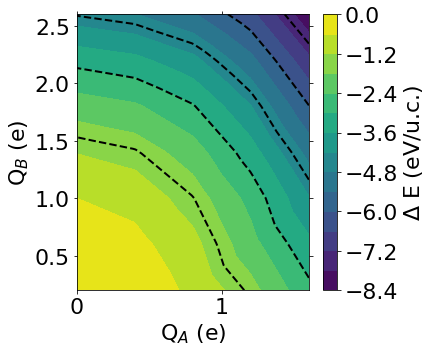

In [53]:
diff_11 = vary_charges(Q_a, Q_b, write_221, write_11, 4, disp=40.)
plot_difference(diff_11, savefile='Figures/221_11_varQ_disp100.png')

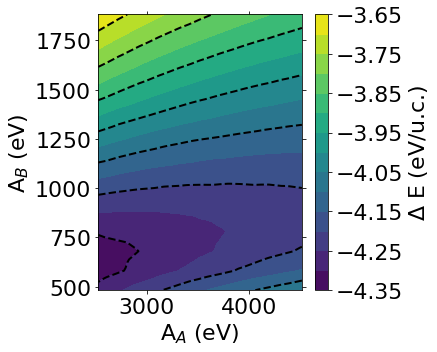

In [54]:
diff_11 = vary_repulsion(exp_a, exp_b, write_221, write_11, 4)
plot_difference_radius(diff_11, savefile='Figures/221_11_varExp_disp40.png')

## Spacegroup 127


Here we explore the energy difference between spacegroup 127 and spacegroup 221.

We first of all vary the charges on site A and B - looking at `C` parameters for dispersion of (i) 40, (ii) 100 and (iii) 0. Then we vary the repulsion on A and B.

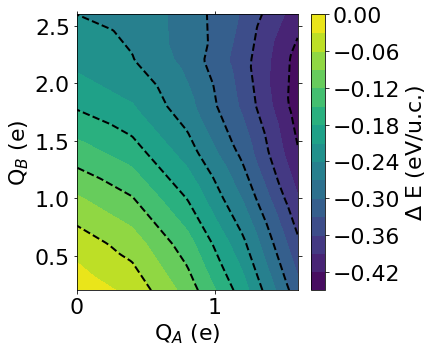

In [51]:
diff_127 = vary_charges(Q_a, Q_b, write_221, write_127, 2)
plot_difference(diff_127, savefile='Figures/221_127_varQ_disp40.png')

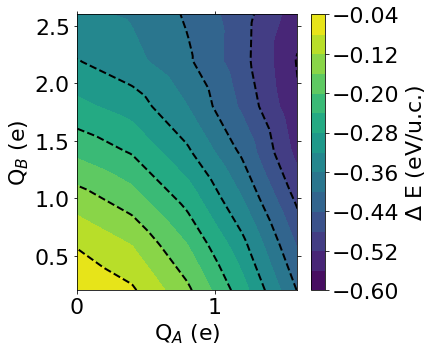

In [55]:
diff_127 = vary_charges(Q_a, Q_b, write_221, write_127, 2, disp=100.)
plot_difference(diff_127, savefile='Figures/221_127_varQ_disp100.png')

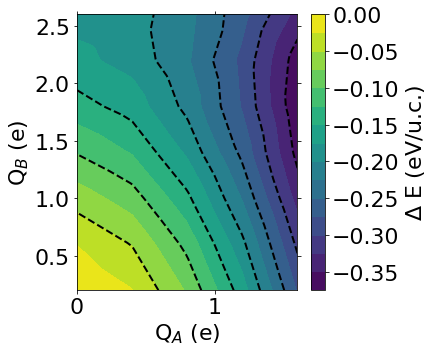

In [56]:
diff_127 = vary_charges(Q_a, Q_b, write_221, write_127, 2, disp=0.)
plot_difference(diff_127, savefile='Figures/221_127_varQ_disp0.png', display=False)

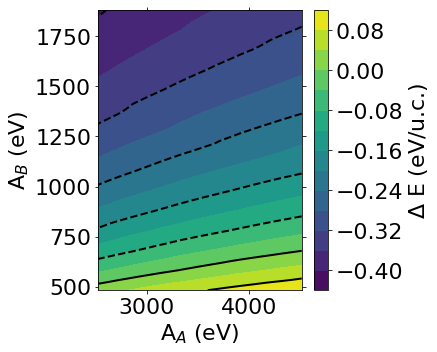

In [57]:
diff_127 = vary_repulsion(exp_a, exp_b, write_221, write_127, 2)
plot_difference_radius(diff_127, savefile='Figures/221_127_varExp_disp40.png')

## Spacegroup 140

Here we explore the energy difference between spacegroup 140 and spacegroup 221.

We first of all vary the charges on site A and B - looking at `C` parameters for dispersion of (i) 40, (ii) 100 and (iii) 0. Then we vary the repulsion on A and B.

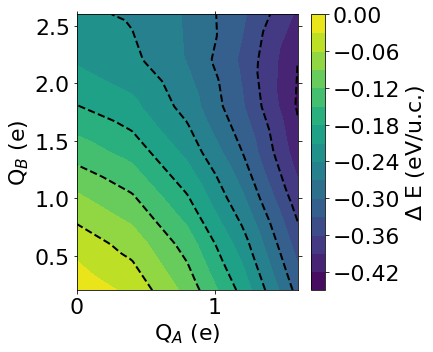

In [58]:
diff_140 = vary_charges(Q_a, Q_b, write_221, write_140, 2)
plot_difference(diff_140, savefile='Figures/221_140_varQ_disp40.png')

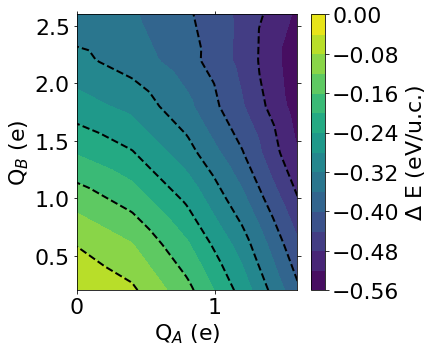

In [59]:
diff_140 = vary_charges(Q_a, Q_b, write_221, write_140, 2, disp=100.)
plot_difference(diff_140, savefile='Figures/221_140_varQ_disp100.png')

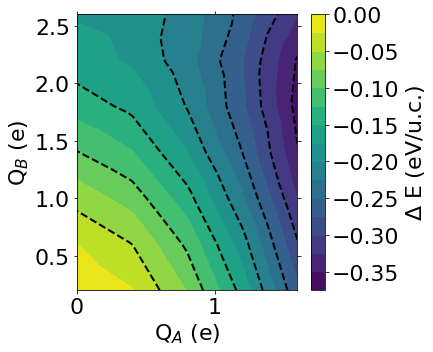

In [60]:
diff_140 = vary_charges(Q_a, Q_b, write_221, write_140, 2, disp=0.)
plot_difference(diff_140, savefile='Figures/221_140_varQ_disp0.png')

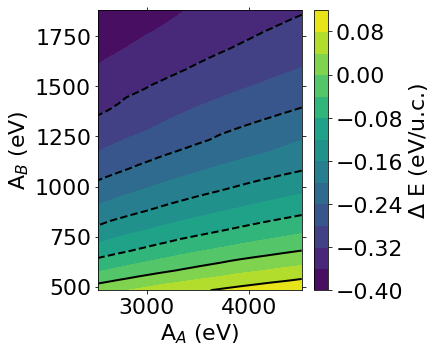

In [61]:
diff_140 = vary_repulsion(exp_a, exp_b, write_221, write_140, 2)
plot_difference_radius(diff_140, savefile='Figures/221_140_varExp_disp40.png')

## Spacegroup 140

Here we explore the energy difference between spacegroup 140 and spacegroup 127.

We first of all vary the charges on site A and B. Then we vary the repulsion on A and B.

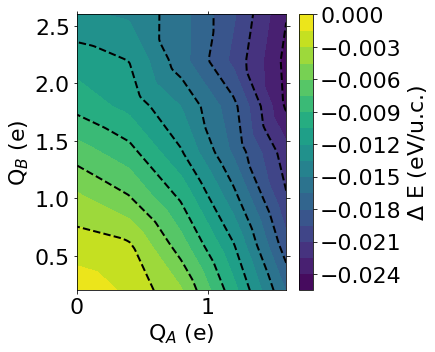

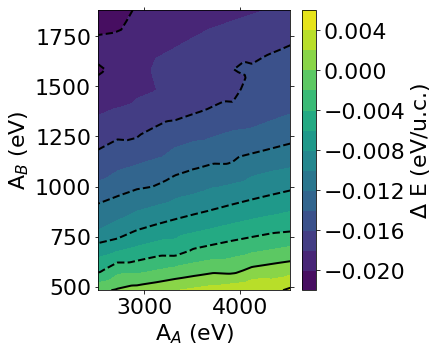

In [64]:
diff_140_127 = vary_charges(Q_a, Q_b, write_140, write_127, 1, disp=40.)
plot_difference(diff_140_127, savefile='Figures140_127_varQ_disp100.png', display=False)
diff_140_127 = vary_repulsion(exp_a, exp_b, write_140, write_127, 1)
plot_difference_radius(diff_140_127)

## Spacegroup 62

Here we explore the energy difference between spacegroup 62 and spacegroup 221.

We first of all vary the charges on site A and B - looking at `C` parameters for dispersion of (i) 40, (ii) 100 and (iii) 0. Then we vary the repulsion on A and B.

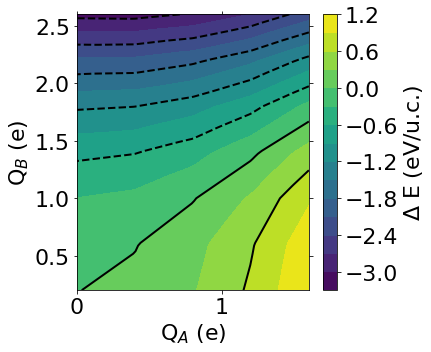

In [65]:
diff_62 = vary_charges(Q_a, Q_b, write_221, write_62, 4)
plot_difference(diff_62, savefile='Figures/221_62_varQ_disp40.png')

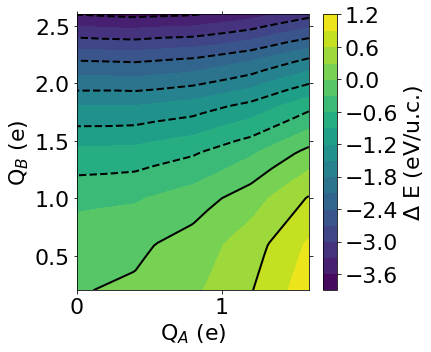

In [66]:
diff_62 = vary_charges(Q_a, Q_b, write_221, write_62, 4, disp=100.)
plot_difference(diff_62, savefile='Figures/221_62_varQ_disp100.png')

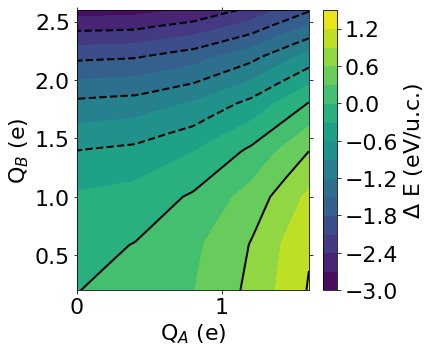

In [67]:
diff_62 = vary_charges(Q_a, Q_b, write_221, write_62, 4, disp=0.)
plot_difference(diff_62, savefile='Figures/221_62_varQ_disp0.png')

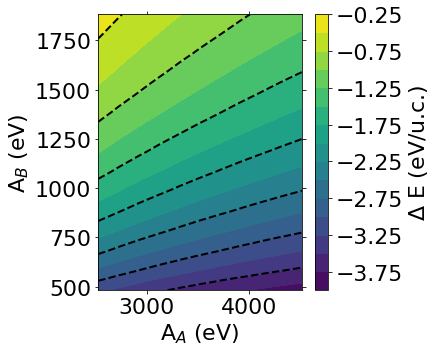

In [68]:
diff_62 = vary_repulsion(exp_a, exp_b, write_221, write_62, 4)
plot_difference_radius(diff_62, savefile='Figures/221_62_varExp_disp40.png')